<a href="https://colab.research.google.com/github/AIR-UFG/pfc-victor/blob/main/SimpleTruco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# media das avg game value
# duas cartas
## CFR+ (https://arxiv.org/pdf/1407.5042.pdf)

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt
from time import time
from random import shuffle
from collections import OrderedDict
from IPython.display import clear_output
from abc import ABC, abstractmethod
from tqdm import tqdm

# Simplified Truco

* Quatro ações principais: `c, p, b, D` (call, pass, bet e draw card)
* `D` é jogar uma carta válida e será representada pela string que define a carta
* O baralho será composto por 5 cartas: 1 zap (`Z`), 2 cartas médias (`N`) e 2 cartas fracas (`R`)
* A força será : `Z` $>$ `N` $>$ `R`
* A força será representada pelos valores inteiros $10$, $5$ e $0$

Globais para o jogo

In [3]:
# acoes
CALL = 0
PASS = 1
BET = 2
PLAY_CARD = 3

NUM_ACTIONS = 5

VOICE_ACTIONS = [CALL, PASS, BET]

CARDS_DECK = [10, 5, 5, 0, 0]

CARD_NAME = {
    10: 'Z',
    5: 'N',
    0: 'R'
}

# maximo de 'truco'
MAX_BET = 2

# index dos jogadores
PLAYER_0 = 0
PLAYER_1 = 1

N_PLAYERS = 2
CARDS_IN_HAND = 1

CARDS_PER_TEAM = 2*CARDS_IN_HAND

## Implementação do jogo

In [4]:
class SimpleTruco():

    def __init__(self):
        self.card_strength = {'Z': 10, 'N': 5, 'R': 0}
        self.payoff_value = 0
        self.regex_all_played = re.compile("(((b(bb)?c)|(bb))?[ZNR]){4}")


    def is_terminal(self, game_history):
        terminal_state = False

        valid_history = self.check_history_valid(game_history)

        if valid_history:
            opponent_ran = self.check_quitter(game_history)
            all_cards_played = self.check_all_played(game_history)

            if opponent_ran or all_cards_played:
                terminal_state = True

        return terminal_state

    def check_history_valid(self, history):
        return (history != '')

    def check_quitter(self, history):
        return (history[-1] == 'p')

    def check_all_played(self, history):
        return self.regex_all_played.search(history)


    def set_payoff_value(self, game_history):
        times_raised = game_history.count('b')

        player, opponent = self.get_player_opponent_index(game_history)
        opponent_ran = self.check_quitter(game_history)

        if opponent_ran:
            payoff_value = max(1, 3*(times_raised - 1))
        else:
            points = max(1, 3*times_raised)
            winner = self.get_winner(game_history)

            if winner == player:
                reward = 1
            elif winner == opponent:
                reward = -1
            else:
                reward = 0

            payoff_value = reward*points

        self.payoff_value = payoff_value
        return

    def get_player_opponent_index(self, history):
        player = len(history) % 2
        opponent = 1 - player

        return (player, opponent)

    def get_winner(self, history):
        winner = -1
        actions = self.get_player_actions(history)

        if self.check_quitter(actions[PLAYER_0]):
            winner = PLAYER_1
        elif self.check_quitter(actions[PLAYER_1]):
            winner = PLAYER_0
        else:
            cards = self.get_player_cards(actions)
            max_card_p0, max_card_p1 = self.get_player_max_card(cards)

            if max_card_p0 > max_card_p1:
                winner = PLAYER_0
            elif max_card_p0 < max_card_p1:
                winner = PLAYER_1

        return winner

    def get_player_actions(self, history):
        player_actions = {}

        player_actions[PLAYER_0] = history[::2]
        player_actions[PLAYER_1] = history[1::2]

        return player_actions

    def get_player_cards(self, actions):
        player_cards = {}

        player_cards[PLAYER_0] = re.findall(r'[ZNR]', actions[PLAYER_0])
        player_cards[PLAYER_1] = re.findall(r'[ZNR]', actions[PLAYER_1])

        return player_cards

    def get_player_max_card(self, cards):
        p0_strength = [self.card_strength[card] for card in cards[PLAYER_0]]
        p1_strength = [self.card_strength[card] for card in cards[PLAYER_1]]

        p0_max = max(p0_strength)
        p1_max = max(p1_strength)

        return p0_max, p1_max


    def possible_actions(self, infoset):
        complete_hand, game_history = infoset.split('#')

        player, opponent = self.get_player_opponent_index(game_history)
        actions = self.get_player_actions(game_history)

        is_raise_sequence = re.search(r'((?<=[cZNR])(b+)$)|^b+$', game_history)

        times_raised = game_history.count('b')
        times_played = len(re.findall('[ZNR]', actions[player]))

        hand_turn = times_played % 2

        playable_cards = self.get_playable_cards(complete_hand, hand_turn)

        if is_raise_sequence:
            raise_sequence = is_raise_sequence.group()

            possible_actions = self.answer_raise_sequence(raise_sequence,
                                                          times_raised)
        else:
            possible_actions = self.normal_actions(actions[player],
                                                   actions[opponent],
                                                   times_raised)

        possible_actions = self.insert_cards(possible_actions, playable_cards)
        return possible_actions

    def answer_raise_sequence(self, raise_sequence, n_raise):
        p_actions = [PASS]

        if n_raise < MAX_BET:
            p_actions.append(BET)

        accept_bet = self.check_bet_acceptance(raise_sequence)
        p_actions.append(accept_bet)

        return p_actions

    def normal_actions(self, player_actions, opponent_actions, n_raised):
        p_actions = [PLAY_CARD]
        can_bet = self.check_bet_possibility(player_actions,
                                             opponent_actions)

        if can_bet and (n_raised < MAX_BET):
            p_actions.append(BET)

        return p_actions

    def check_bet_acceptance(self, raise_sequence):
        if (len(raise_sequence) % 2):
            accept_action = CALL
        else:
            accept_action = PLAY_CARD

        return accept_action

    def check_bet_possibility(self, player_actions, opponent_actions):
        possibility = True

        player_last_bet = player_actions.rfind('b')
        opponent_last_bet = opponent_actions.rfind('b')

        if player_last_bet > opponent_last_bet:
            possibility = False

        return possibility

    def get_playable_cards(self, all_hands, turn):
        offset = self.get_offset(turn)
        playable_hand = all_hands.split('|')[turn]
        playable_cards = [offset + i for i, char in enumerate(playable_hand) if char != '.']

        return playable_cards

    def get_offset(self, turn):
        return PLAY_CARD + turn*CARDS_IN_HAND

    def insert_cards(self, p_actions, cards):
        if PLAY_CARD not in p_actions:
            return p_actions

        new_actions = p_actions
        new_actions.remove(PLAY_CARD)

        new_actions += cards
        return new_actions

## Funções auxiliares

In [5]:
def get_string(action, info_set):
    string_action = {
        0: 'c',
        1: 'p',
        2: 'b'
    }

    if action < 3:
        return string_action[action]

    cards = info_set.split('#')[0]
    cards = cards.replace('|', '')
    played_card = cards[action - PLAY_CARD]
    return played_card

def play_card(index, cards):
    new_cards = cards
    correct_index = index - PLAY_CARD

    if correct_index >= CARDS_IN_HAND:
        correct_index += 1

    new_cards = new_cards[:correct_index] + '.' + new_cards[correct_index+1:]
    return new_cards

def get_infoset_name(cards, history):
    return cards + '#' + history

# Node and CFR definition

## Node

In [6]:
class Node:

    def __init__(self, info_set_id, possible_actions):
        self.n_visits = 0
        self.info_set = info_set_id
        self.possible_actions = possible_actions

        self.strategy = [0] * NUM_ACTIONS
        self.regret_sum = [0] * NUM_ACTIONS
        self.strategy_sum = [0] * NUM_ACTIONS


    def get_strategy(self, p_opponent):
        normalizing_sum = 0

        for action in self.possible_actions:
            self.strategy[action] = self.regret_sum[action]\
                                    if self.regret_sum[action] > 0\
                                    else 0

            normalizing_sum += self.strategy[action]

        for action in self.possible_actions:
            if normalizing_sum > 0:
                self.strategy[action] /= normalizing_sum
            else:
                self.strategy[action] = 1/len(self.possible_actions)

            self.strategy_sum[action] += p_opponent*self.strategy[action]

        return self.strategy


    def get_average_strategy(self):
        avg_strategy = [0] * NUM_ACTIONS
        normalizing_sum = sum(self.strategy_sum)

        for action in self.possible_actions:
            if normalizing_sum > 0:
                avg_strategy[action] = self.strategy_sum[action]/normalizing_sum
            else:
                avg_strategy[action] = 1/len(self.possible_actions)

        return avg_strategy


    def __str__(self):
        # o Infomation Set é definido pela carta na mao do jogador e a sequencia de acoes
        return f'(V: {self.n_visits}) {self.info_set}: {self.get_average_strategy()}'

## CFR

In [7]:
def ChanceSampling_CFR(cards, history, p0, p1):
    n_plays = len(history)

    player = n_plays % 2
    opponent = 1 - player

    player_cards = cards[player]

    if game.is_terminal(history):
        game.set_payoff_value(history)
        return game.payoff_value

    # get infoset node or create new
    info_set = get_infoset_name(player_cards, history)
    node = NODE_MAP.get(info_set)

    if node is None:
        node_possible_actions = game.possible_actions(info_set)

        node = Node(info_set, node_possible_actions)
        NODE_MAP[info_set] = node

    node.n_visits += 1

    if node.n_visits < NODE_MAP['minimo'][1]:
        NODE_MAP['minimo'] = (info_set, node.n_visits)
    elif info_set == NODE_MAP['minimo'][0]:
        NODE_MAP['minimo'] = (info_set, node.n_visits)

    # recursively call CFR with +action +history for each action
    player_probability = (p0 if player == 0 else p1)
    strategy = node.get_strategy(player_probability)

    util = [0] * NUM_ACTIONS
    node_util = 0

    possible_actions = node.possible_actions
    for action in possible_actions:
        next_history = history + get_string(action, info_set)
        next_cards = cards.copy()

        if action not in VOICE_ACTIONS:
            next_cards[player] = play_card(action, player_cards)

        util[action] = -ChanceSampling_CFR(next_cards, next_history, p0*strategy[action], p1)\
                       if player == 0 else \
                       -ChanceSampling_CFR(next_cards, next_history, p0, p1*strategy[action])

        node_util += strategy[action]*util[action]

    # accumulate counterfactual regret for each action
    for action in possible_actions:
        regret = util[action] - node_util
        node.regret_sum[action] += player_probability * regret

    return node_util

* Identificador do **infoset** será definido como o histórico de ações tomadas e as cartas na mão do jogador.

* Caracteres especiais:

    * \# -> separa cartas do histórico
    * | -> separa mão dos jogadores de um mesmo time
    * . -> indica que a carta daquela posição já foi jogada
    * \* -> indica que não é possível ver a carta

* Exemplo: `ZR|.N#bcRN`

# Treino

In [8]:
def sample_cards():
    complete_hands = []
    teams = np.random.choice(CARDS_DECK,
                             size=(N_PLAYERS, CARDS_PER_TEAM, CARDS_IN_HAND),
                             replace=False)

    for team in teams:
        team_hand = []
        for hand in team:
            cards = ''
            for card in hand:
                cards += CARD_NAME[card]

            team_hand.append(cards)
        complete_hands.append('|'.join(team_hand))

    return complete_hands

## Treino por estabilidade

In [9]:
def stable_train():
    util_history = []
    proportion_history = []

    iterations = 0
    n_estability = 0
    previous_set_number = 0

    start_time = time()

    while True:
        reached_estability = (n_estability >= MIN_ESTABILITY)
        visited_minimun = (NODE_MAP['minimo'][1] >= MIN_VISITS)

        if  reached_estability and visited_minimun:
            break

        iterations += 1
        team_cards = sample_cards()

        new_util = ChanceSampling_CFR(team_cards, "", 1, 1)
        current_set_number = len(NODE_MAP)

        util_history.append(new_util)
        proportion_history.append(sum(util_history)/iterations)

        if current_set_number != previous_set_number:
            previous_set_number = current_set_number
            n_estability = 0
        else:
            n_estability += 1

    end_time = time()

    print(f'Elapsed time: {end_time - start_time:.2f}s')
    print(f'Total de iteracoes: {iterations}')
    print(f'Avg game value: {sum(util_history)/iterations}')

    return (proportion_history, iterations)

In [10]:
MIN_ESTABILITY = 50
MIN_VISITS = 100

NODE_MAP = OrderedDict()
NODE_MAP['minimo'] = ('#', 10)

game = SimpleTruco()
avg_util, iterations = stable_train()

Elapsed time: 2.40s
Total de iteracoes: 3341
Avg game value: -0.09629315594775935


In [11]:
len(NODE_MAP)

799

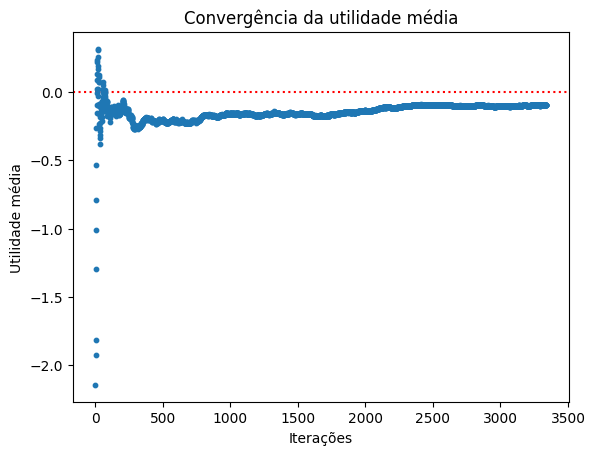

In [12]:
plt.scatter(y=avg_util, x=np.arange(iterations), s=10)
plt.axline((0,0), slope=0, color='red', linestyle=':', zorder=0)
plt.xlabel('Iterações')
plt.ylabel('Utilidade média')
plt.title('Convergência da utilidade média')
plt.show()

## Treino puro

In [13]:
def pure_train(iterations):
    util = 0

    start_time = time()

    for i in range(iterations):
        team_cards = sample_cards()
        util += ChanceSampling_CFR(team_cards, "", 1, 1)

    end_time = time()

    print('#### Pure training')
    print(f'Elapsed time: {end_time - start_time:.2f}s')
    print(f'Avg game value: {util/iterations}')
    return

In [14]:
NODE_MAP = OrderedDict()
NODE_MAP['minimo'] = ('#', 10)

game = SimpleTruco()
pure_train(iterations = 3500)

#### Pure training
Elapsed time: 2.22s
Avg game value: -0.057120983096862143


In [15]:
len(NODE_MAP)

799

##### Visualização Node Map

In [ ]:
for node in NODE_MAP.values():
    print(node)

# Jogando

Seção destinada a implementar uma interface que possibilite testar o jogo Simple Truco, bem como testar duas políticas CFR jogando entre si.

## Modelagem

Implementação das políticas e do controlador para ser possível jogar.

In [16]:
# interface para politicas, todas devem implementar o metodo take_action
class Policy(ABC):

    @abstractmethod
    def take_action(self):
        return

In [17]:
class HumanPolicy(Policy):

    def take_action(self, infoset):
        action = -1

        self.print_game_guide(infoset)

        action = int(input('O que ira fazer? '))
        clear_output(wait=True)

        return action

    def print_game_guide(self, infoset):
        hand_cards, history = infoset.split('#')

        print(f'Jogo ate aqui: {history}')

        print('\nLegenda para acoes:')
        print('\n0 -> Aceitar truco\n1 -> Correr...')
        print('2 -> TRUCO!\n3+ -> Jogar carta', end='\n\n')

        print(f'Cartas na mao -> {hand_cards}')
        return


class CFRPolicy(Policy):

    def __init__(self, NODE_MAP):
        self.actions = [i for i in range(NUM_ACTIONS)]
        self.NODE_MAP = NODE_MAP

    def take_action(self, infoset):
        infoset_node = self.NODE_MAP[infoset]
        action_probability = infoset_node.get_average_strategy()

        action_vector = np.random.choice(self.actions,
                                         size=1,
                                         p=action_probability)

        action = action_vector[0]
        return action

In [28]:
class PlayGame():

    def __init__(self, policy_0, policy_1, game):
        self.players = [policy_0, policy_1]
        self.game = game
        self.turn = 0


    def play_game(self, verbose=False):
        all_cards = sample_cards()
        history = ''

        while True:
            player_cards = all_cards[self.turn]
            current_player = self.players[self.turn]

            infoset = get_infoset_name(player_cards, history)

            if self.game.is_terminal(history):
                break

            possible_actions = self.game.possible_actions(infoset)
            action_made = -1

            if verbose:
                print(f'Acoes possiveis: {possible_actions}')

            while action_made not in possible_actions:
                action_made = current_player.take_action(infoset)

            if action_made not in VOICE_ACTIONS:
                all_cards[self.turn] = play_card(action_made, player_cards)

            self.turn = (self.turn + 1)%2
            history += get_string(action_made, infoset)

            if verbose:
                clear_output(wait=True)

        winner_player = self.game.get_winner(history)
        return (winner_player, infoset)

## Jogo _Humano **x** CFR_

In [29]:
player_0 = HumanPolicy()
player_1 = CFRPolicy(NODE_MAP)
simple_truco = SimpleTruco()

new_game = PlayGame(player_0, player_1, simple_truco)

In [39]:
winner, final = new_game.play_game(verbose=True)

print(f'Ganhador -> {winner}')
print(f'Final -> {final}')

Ganhador -> 1
Final -> .|R#RNNbp


## Jogo _CFR **x** CFR_

In [22]:
# parametros para testes
n_games = int(1e+3)
cards = [10, 5, 5, 0, 0]

win_history = {
    0: 0,
    1: 0,
    -1: 0
}

player_0 = CFRPolicy(NODE_MAP)
player_1 = CFRPolicy(NODE_MAP)

In [23]:
for i in tqdm(range(n_games)):
    shuffle(cards)

    new_game = PlayGame(player_0, player_1, game)

    winner, infoset = new_game.play_game()
    win_history[winner] += 1

print(f'\n{win_history}')

100%|██████████| 1000/1000 [00:00<00:00, 3059.92it/s]


{0: 445, 1: 550, -1: 5}


* Realizando $1.000$ jogos entre dois jogadores com a `CFRPolicy` o desempenho foi como o esperando, sinalizando uma implementação correta do algoritmo.

* Uma das hipóteses para o leve desequilíbrio para o segundo jogador (P1) é o jogo ainda ser muito simples. Uma vez que P1 sempre joga com mais informações na mesa que P0, terá uma vantagem em calcular melhor o retorno de suas ações.

* Taxa de vitórias:
    - Jogador 0 (P0): $44,5$%
    - Jogador 1 (P1): $55,0$%
    - Empate: $00,5$%


# Treino com testes
implementar treino que joga contra si